In [8]:
!pip install lightning -q

In [9]:
import os

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

import lightning as L

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [10]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

Tesla P100-PCIE-16GB


In [11]:
BATCH_SIZE = 512
NUM_WORKERS = 4
MAX_EPOCHS = 30
LEARNING_RATE = 1e-2
DROPOUT = 0.3
NUM_CLASSES = len(os.listdir("/kaggle/input/fruits-classification/Fruits Classification/train"))
LAST_LAYER = -2
DATA_DIR = "/kaggle/input/fruits-classification/Fruits Classification"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}, Data Dir: {DATA_DIR}, Num Classes: {NUM_CLASSES}")
class_names = sorted(os.listdir("/kaggle/input/fruits-classification/Fruits Classification/train"))
print(class_names)

Device: cuda:0, Data Dir: /kaggle/input/fruits-classification/Fruits Classification, Num Classes: 5
['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [12]:
class FruitsDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size,transform=None, augmented_transform=None, target_transform=None, num_workers=0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform
        self.augmented_transform = augmented_transform or transform
        self.target_transform=target_transform
        self.num_workers = num_workers
        self.persistent_workers = True if num_workers else False
        
        self.train_dir = os.path.join(data_dir, "train")
        self.valid_dir = os.path.join(data_dir, "valid")
        self.test_dir = os.path.join(data_dir, "test")

#     def setup(self, stage=None):
        self.train_set = ImageFolder(root=self.train_dir, transform=self.augmented_transform, target_transform=self.target_transform)
        self.valid_set = ImageFolder(root=self.valid_dir, transform=self.transform, target_transform=self.target_transform)
        self.test_set = ImageFolder(root=self.test_dir, transform=self.transform, target_transform=self.target_transform)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, pin_memory=True, num_workers=self.num_workers, persistent_workers=self.persistent_workers)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid_set, batch_size=self.batch_size, pin_memory=True, num_workers=self.num_workers, persistent_workers=self.persistent_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=True, pin_memory=True, num_workers=self.num_workers, persistent_workers=self.persistent_workers)

In [13]:
transform = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
    ])

dm = FruitsDataModule(data_dir=DATA_DIR, batch_size=BATCH_SIZE, transform=transform, num_workers=NUM_WORKERS, target_transform=None)

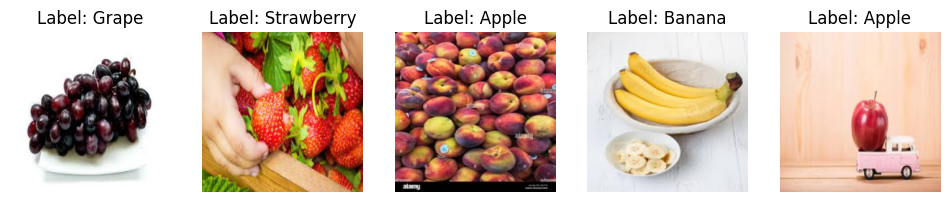

In [14]:

def show_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1,2,0))
        ax.set_title(f'Label: {class_names[labels[i].item()]}')
        ax.axis('off')
    plt.show()

show_sample_images(dm.test_dataloader())

# Basic CNN

In [15]:
class SimpleCNNModel(L.LightningModule):
    def __init__(self, num_classes=5, dropout=0.2, learning_rate=0.001):
        super(SimpleCNNModel, self).__init__()
        self.learning_rate = learning_rate
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(6272, 128),  
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)

        y_pred = torch.argmax(y_hat, dim=1).cpu().numpy()
        y_true = y.cpu().numpy()

        train_acc = accuracy_score(y_true, y_pred)
        train_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
        train_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
        train_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
        
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', train_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_precision', train_precision, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_recall', train_recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_f1', train_f1, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        
        y_pred = torch.argmax(y_hat, dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
        
        val_acc = accuracy_score(y_true, y_pred)
        val_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
        val_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
        val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc', val_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_precision', val_precision, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_recall', val_recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_f1', val_f1, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        
        y_pred = torch.argmax(y_hat, dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
        
        test_acc = accuracy_score(y_true, y_pred)
        test_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
        test_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
        test_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
        
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_acc', test_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_precision', test_precision, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_recall', test_recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_f1', test_f1, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }


simple_model = SimpleCNNModel(num_classes=NUM_CLASSES, dropout=0.2, learning_rate=0.001)

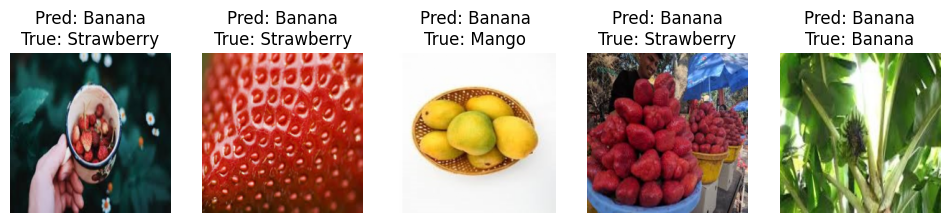

Accuracy: 20.00%


In [16]:
def plot_predictions(model, loader):
    model.eval()  
    correct = 0
    total = 0
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        accuracy = correct / total * 100
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1,2,0))
        ax.set_title(f'Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}')
        ax.axis('off')
    plt.show()
    
    print(f'Accuracy: {accuracy:.2f}%')

plot_predictions(simple_model, dm.test_dataloader())

In [17]:
augmented_transform = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ])


transform = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ])

dm = FruitsDataModule(data_dir=DATA_DIR, batch_size=BATCH_SIZE, transform=transform, augmented_transform=augmented_transform, num_workers=NUM_WORKERS, target_transform=None)


In [18]:
trainer = L.Trainer(max_epochs=MAX_EPOCHS, devices=-1, precision="16-mixed", deterministic=True,)
trainer.fit(simple_model, datamodule=dm)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2024-08-04 00:30:14.123888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 00:30:14.124014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 00:30:14.251022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type       | Params | Mode
--------------------------------------------
0 | model | Sequential | 1.2 M  | eval
---

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [19]:
trainer.test(simple_model, datamodule=dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7900000214576721     │
│          test_f1          │    0.7912551760673523     │
│         test_loss         │    0.7843477725982666     │
│      test_precision       │    0.8009209632873535     │
│        test_recall        │    0.7900000214576721     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_loss': 0.7843477725982666,
  'test_acc': 0.7900000214576721,
  'test_precision': 0.8009209632873535,
  'test_recall': 0.7900000214576721,
  'test_f1': 0.7912551760673523}]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


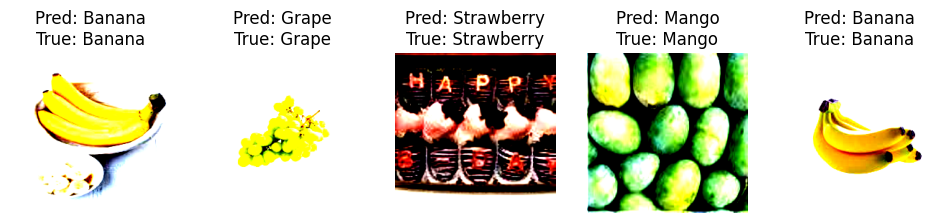

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 79.00%


In [20]:
plot_predictions(simple_model, dm.test_dataloader())

# Fine Tuning EfficientNet_V2s

In [21]:
class FineTuneEfficientNet(SimpleCNNModel):
    def __init__(self, num_classes=5, dropout=0.2, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.backbone = models.efficientnet_v2_s(weights="DEFAULT")
        
        for param in list(self.backbone.parameters()):
            param.requires_grad = False
        
        num_features = self.backbone.classifier[1].in_features
        
        self.backbone.classifier = nn.Identity()  
        
        dim=128
        self.model = nn.Sequential(
            self.backbone,
            nn.Linear(num_features, dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, num_classes)
        )
                
effnet_model = FineTuneEfficientNet(num_classes=NUM_CLASSES, dropout=0.2, learning_rate=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 155MB/s]


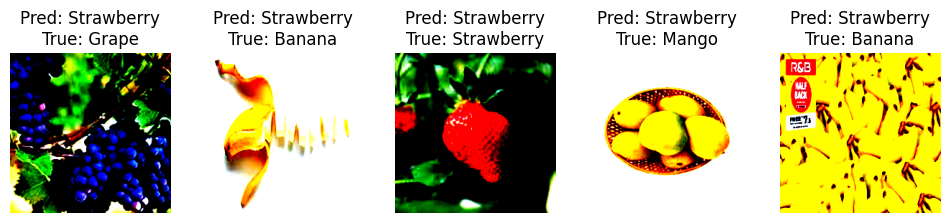

Accuracy: 20.00%


In [22]:
plot_predictions(effnet_model, dm.test_dataloader())

In [23]:
trainer = L.Trainer(max_epochs=MAX_EPOCHS, devices=-1, precision="16-mixed", deterministic=True,)
trainer.fit(effnet_model, datamodule=dm)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type         | Params | Mode
-------------------------------------------------
0 | model    | Sequential   | 20.3 M | eval
1 | backbone | EfficientNet | 20.2 M | eval
-------------------------------------------------
164 K     Trainable params
20.2 M    Non-trainable params
20.3 M    Total params
81.368    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [24]:
trainer.test(effnet_model, datamodule=dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9100000262260437     │
│          test_f1          │    0.9088543653488159     │
│         test_loss         │    0.15531010925769806    │
│      test_precision       │     0.909928560256958     │
│        test_recall        │    0.9100000262260437     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_loss': 0.15531010925769806,
  'test_acc': 0.9100000262260437,
  'test_precision': 0.909928560256958,
  'test_recall': 0.9100000262260437,
  'test_f1': 0.9088543653488159}]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


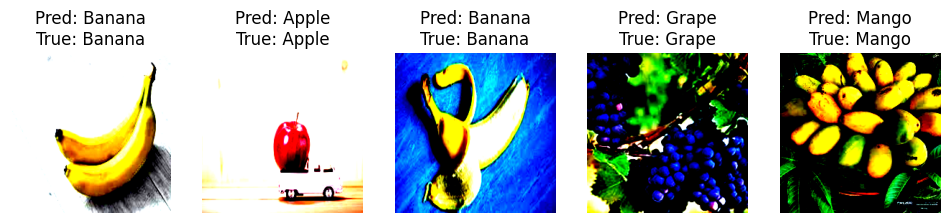

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 91.00%


In [25]:
plot_predictions(effnet_model, dm.test_dataloader())